# ⚠️ Auto-generated Notebook
    
This notebook is automatically compiled from source files in `/workspaces/awesome-matrix/src/examples/04_eigenvalues_eigenvectors`.
**Do not edit this file directly** as your changes will be overwritten.

To make changes:
1. Edit the source file `/workspaces/awesome-matrix/src/examples/04_eigenvalues_eigenvectors/03_applications.py` instead
2. Run the compile script to regenerate this notebook

See [COMPILE.md](docs/COMPILE.md) for more information.


# Applications of Eigenvalues and Eigenvectors

This notebook explores practical applications of eigenvalues and eigenvectors across various fields. We'll implement several real-world examples to demonstrate how these fundamental linear algebra concepts are applied to solve important problems.

## Key Applications We'll Cover

1. **Principal Component Analysis (PCA)** - Dimensionality reduction and data visualization
2. **Image Compression** - Using eigenvalue decomposition to compress images
3. **Vibration Analysis** - Finding natural frequencies and mode shapes
4. **Markov Processes** - Finding steady-state distributions
5. **Graph Analysis** - Spectral clustering and community detection


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from sklearn.datasets import fetch_olivetti_faces, load_digits
from sklearn.cluster import KMeans

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.5)

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


## 1. Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is one of the most common applications of eigenvalues and eigenvectors. It's used for:

- Dimensionality reduction
- Data visualization
- Noise reduction
- Feature extraction

The key insight of PCA is that the eigenvectors of the data covariance matrix point in the directions of maximum variance in the data, with the corresponding eigenvalues indicating how much variance is explained by each direction.

### Let's implement PCA from scratch:


In [2]:
def pca_from_scratch(X, n_components=2):
    """
    Implements PCA from scratch using eigendecomposition of the covariance matrix.
    
    Args:
        X (torch.Tensor): Data matrix of shape (n_samples, n_features)
        n_components (int): Number of principal components to return
        
    Returns:
        tuple: (principal_components, transformed_data, explained_variance_ratio)
    """
    # Center the data
    X_centered = X - X.mean(dim=0, keepdim=True)
    
    # Compute covariance matrix
    n_samples = X.shape[0]
    cov_matrix = (X_centered.T @ X_centered) / (n_samples - 1)
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix)
    
    # Sort eigenvalues and eigenvectors in decreasing order
    idx = torch.argsort(eigenvalues, descending=True)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Select top n_components
    principal_components = eigenvectors[:, :n_components]
    explained_variance = eigenvalues[:n_components]
    explained_variance_ratio = explained_variance / torch.sum(eigenvalues)
    
    # Project data onto principal components
    transformed_data = X_centered @ principal_components
    
    return principal_components, transformed_data, explained_variance_ratio


### Let's apply PCA to the digits dataset for dimensionality reduction and visualization:


Shape of original data: torch.Size([1797, 64])
Shape of transformed data: torch.Size([1797, 2])
Explained variance ratio: tensor([0.1489, 0.1362])
Total variance explained: 28.51%


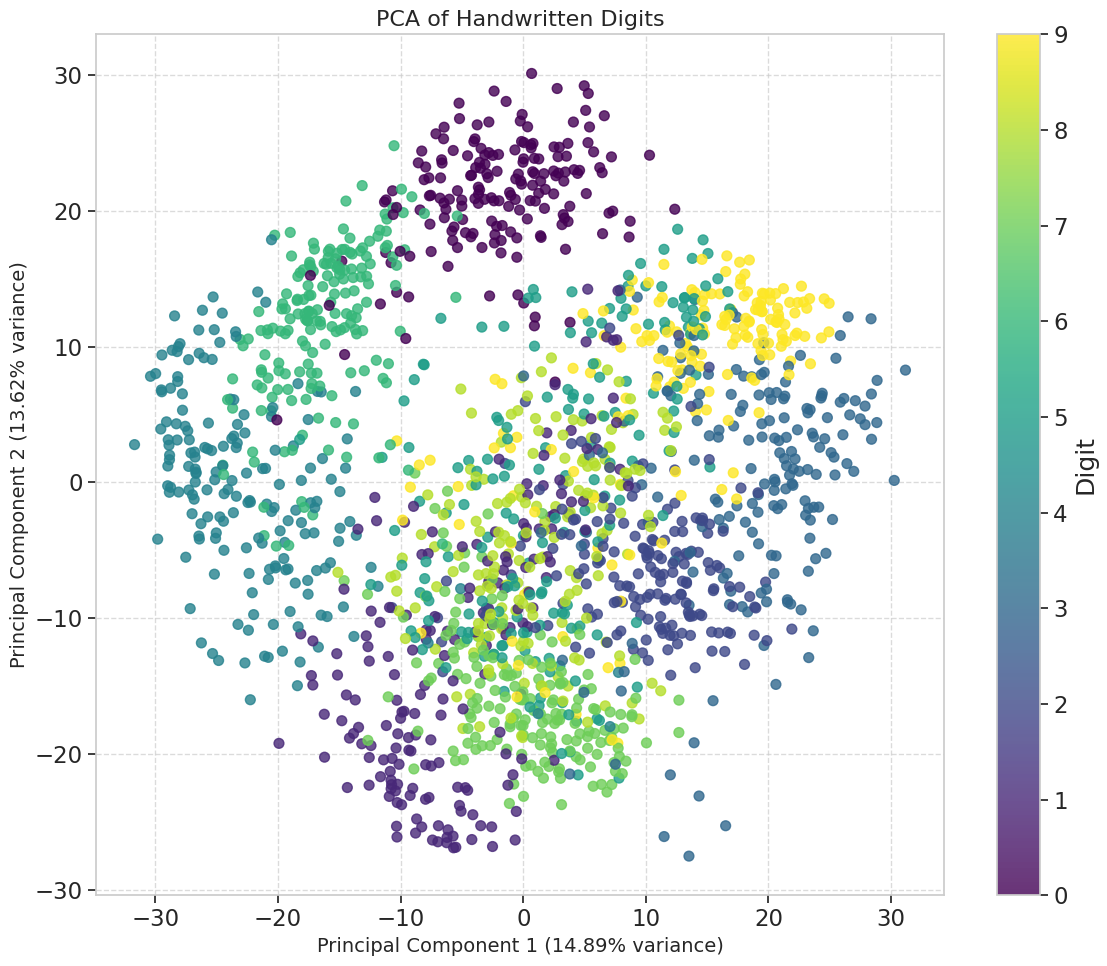

In [3]:
# Load the digits dataset
digits = load_digits()
X_digits = torch.tensor(digits.data, dtype=torch.float32)
y_digits = torch.tensor(digits.target, dtype=torch.long)

# Apply PCA
principal_components, transformed_data, explained_variance_ratio = pca_from_scratch(X_digits, n_components=2)

print(f"Shape of original data: {X_digits.shape}")
print(f"Shape of transformed data: {transformed_data.shape}")
print(f"Explained variance ratio: {explained_variance_ratio}")
print(f"Total variance explained: {torch.sum(explained_variance_ratio).item():.2%}")

# Visualize the results
plt.figure(figsize=(12, 10))

# Create a scatter plot colored by digit class
scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1], 
                     c=y_digits, alpha=0.8, cmap='viridis', s=50)

# Add a colorbar
plt.colorbar(scatter, ticks=range(10), label='Digit')

# Add labels and title
plt.xlabel(f'Principal Component 1 ({explained_variance_ratio[0]:.2%} variance)', fontsize=14)
plt.ylabel(f'Principal Component 2 ({explained_variance_ratio[1]:.2%} variance)', fontsize=14)
plt.title('PCA of Handwritten Digits', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Visualizing the Principal Components

Let's visualize what the principal components actually look like for the digits dataset:


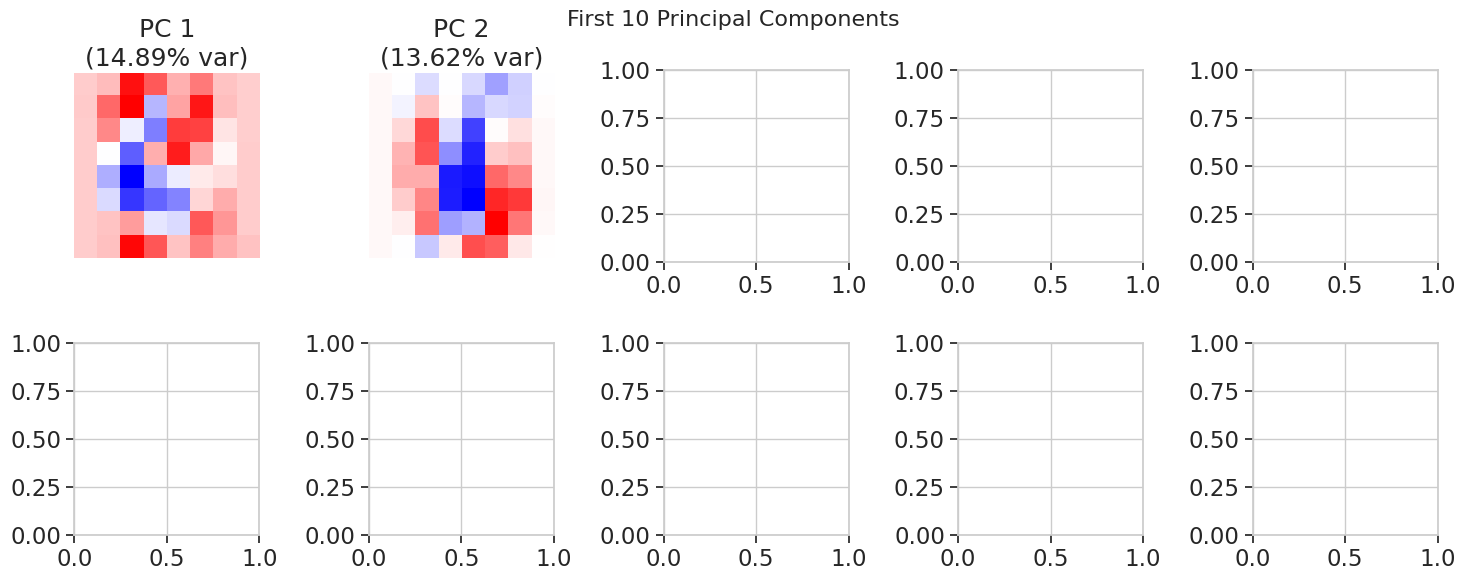

In [4]:
# Reshape principal components to visualize them as images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Plot the first 10 principal components
for i in range(min(10, principal_components.shape[1])):
    # Reshape the principal component to the original image shape
    pc = principal_components[:, i].reshape(8, 8)
    
    # Normalize to [-1, 1] for better visualization
    pc_normalized = 2 * (pc - pc.min()) / (pc.max() - pc.min()) - 1
    
    # Create a diverging colormap where 0 is white
    cmap = LinearSegmentedColormap.from_list("custom_cmap", ['blue', 'white', 'red'])
    
    # Plot
    axes[i].imshow(pc_normalized, cmap=cmap)
    axes[i].set_title(f'PC {i+1}\n({explained_variance_ratio[i]:.2%} var)')
    axes[i].axis('off')

plt.suptitle('First 10 Principal Components', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


### Reconstruction from Principal Components

We can reconstruct the original data using just a few principal components:


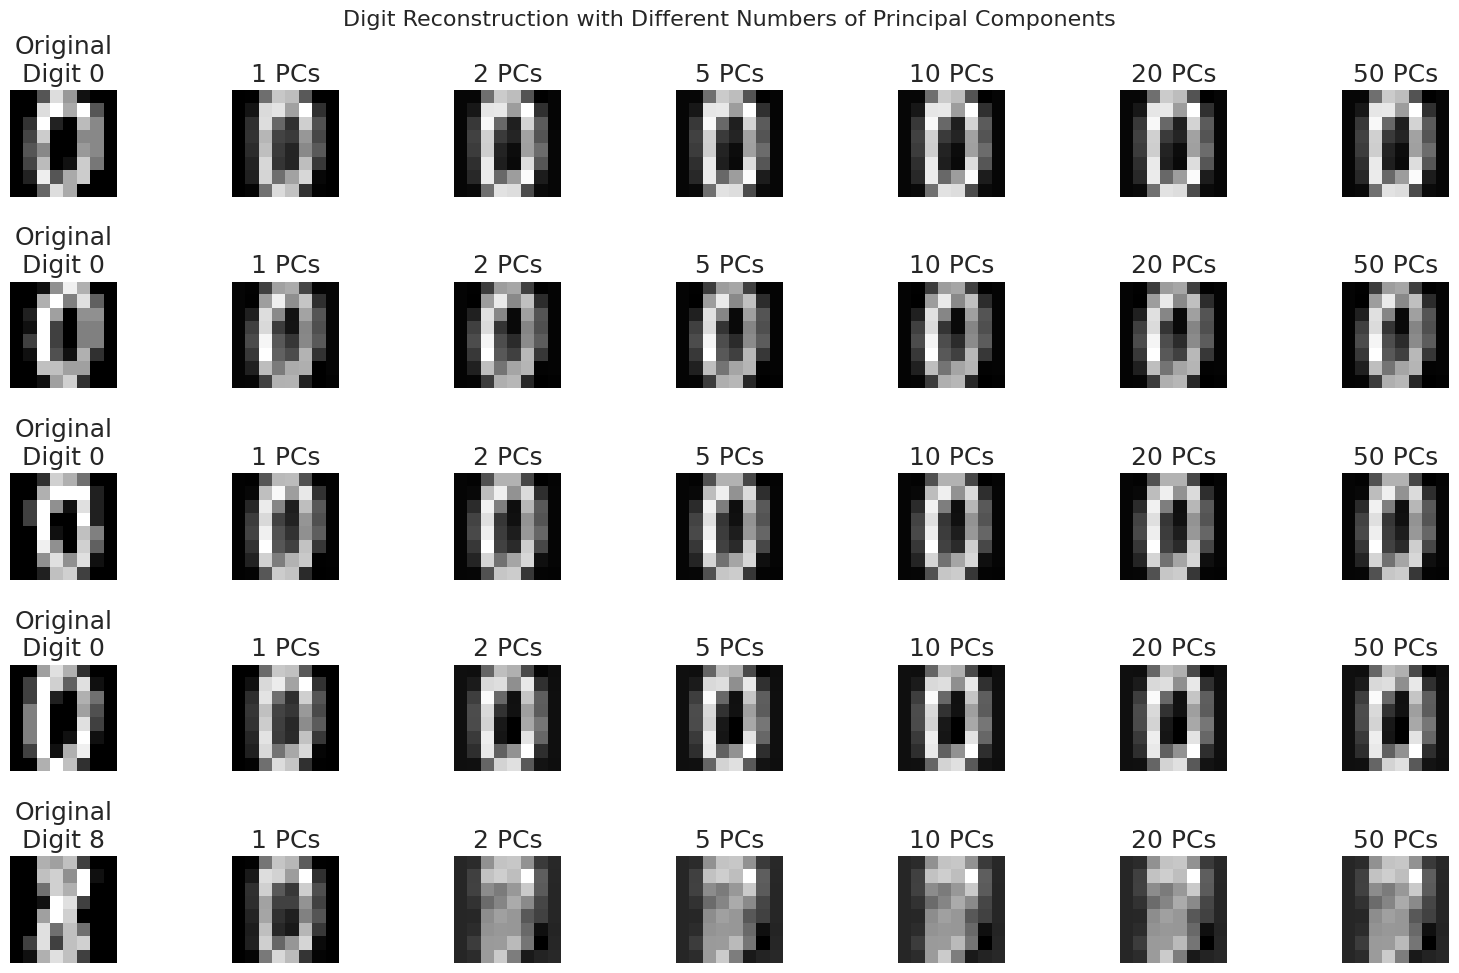

In [5]:
def reconstruct_from_pca(X, principal_components, n_components=None):
    """
    Reconstruct data from its PCA projection.
    
    Args:
        X (torch.Tensor): Original data
        principal_components (torch.Tensor): Principal components
        n_components (int): Number of components to use for reconstruction
        
    Returns:
        torch.Tensor: Reconstructed data
    """
    # Center the data
    X_mean = X.mean(dim=0, keepdim=True)
    X_centered = X - X_mean
    
    # If n_components is specified, use only that many components
    if n_components is not None:
        components = principal_components[:, :n_components]
    else:
        components = principal_components
    
    # Project data onto principal components
    projected = X_centered @ components
    
    # Reconstruct
    reconstructed = projected @ components.T + X_mean
    
    return reconstructed

# Choose a few sample digits
sample_indices = [0, 10, 20, 30, 40]  # One sample from each of the first 5 digits
samples = X_digits[sample_indices]

# Create reconstructions using different numbers of components
n_components_list = [1, 2, 5, 10, 20, 50]
reconstructions = []

for n_comp in n_components_list:
    # Use only the first n_comp principal components
    reconstructed = reconstruct_from_pca(samples, principal_components, n_comp)
    reconstructions.append(reconstructed)

# Visualize original samples and their reconstructions
fig, axes = plt.subplots(len(sample_indices), len(n_components_list) + 1, figsize=(16, 10))

# Plot original images in the first column
for i, idx in enumerate(sample_indices):
    axes[i, 0].imshow(X_digits[idx].reshape(8, 8), cmap='gray')
    axes[i, 0].set_title(f'Original\nDigit {y_digits[idx].item()}')
    axes[i, 0].axis('off')

# Plot reconstructions
for i in range(len(sample_indices)):
    for j, n_comp in enumerate(n_components_list):
        axes[i, j+1].imshow(reconstructions[j][i].reshape(8, 8), cmap='gray')
        axes[i, j+1].set_title(f'{n_comp} PCs')
        axes[i, j+1].axis('off')

plt.suptitle('Digit Reconstruction with Different Numbers of Principal Components', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


## 2. Image Compression

Eigenvalue decomposition, particularly the Singular Value Decomposition (SVD), can be used for image compression. The core idea is to represent an image using only the top few singular values and vectors, which capture most of the important information.

Let's implement SVD-based image compression:


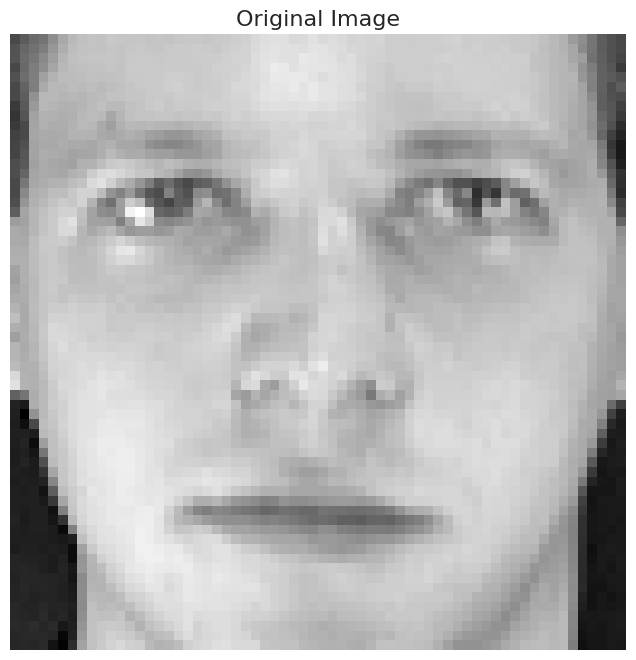

In [6]:
# Function to load an image as a grayscale tensor
def load_image_as_tensor(image_path):
    """Load an image as a PyTorch tensor."""
    # Open image and convert to grayscale
    img = Image.open(image_path).convert('L')
    # Convert to numpy array and then to tensor
    img_array = np.array(img).astype(np.float32)
    img_tensor = torch.tensor(img_array)
    return img_tensor

# Alternatively, let's use a sample image from a dataset
faces = fetch_olivetti_faces()
face_image = torch.tensor(faces.images[0], dtype=torch.float32)

# Display the original image
plt.figure(figsize=(8, 8))
plt.imshow(face_image, cmap='gray')
plt.title('Original Image', fontsize=16)
plt.axis('off')
plt.show()


### Now let's implement and visualize SVD-based image compression:


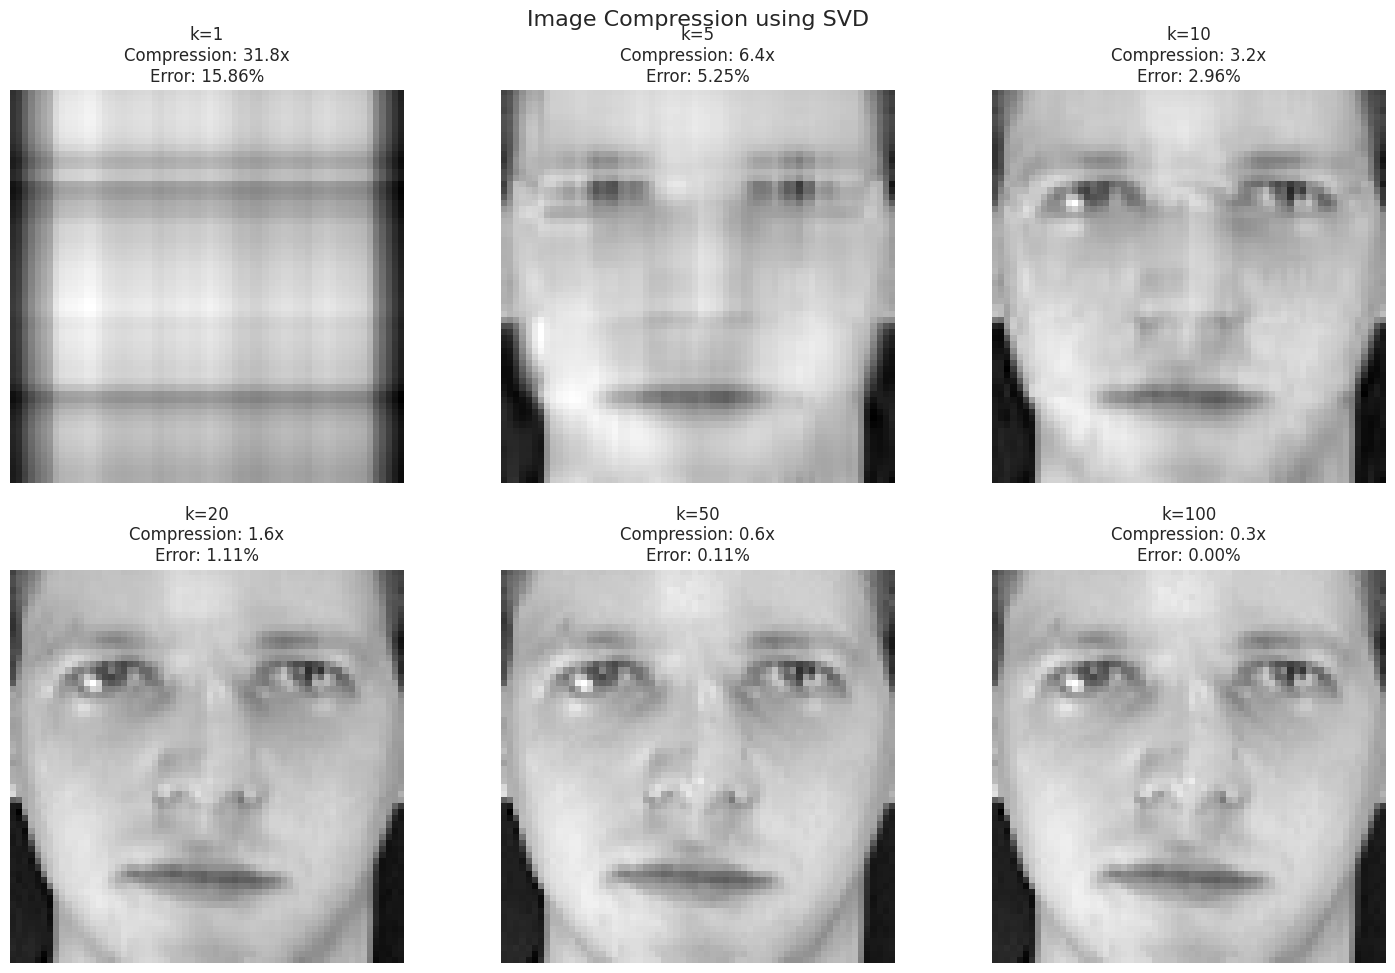

In [7]:
def compress_image_with_svd(image, k):
    """
    Compress image using the top k singular values.
    
    Args:
        image (torch.Tensor): Input image tensor
        k (int): Number of singular values to keep
        
    Returns:
        torch.Tensor: Compressed image
    """
    # Perform SVD
    U, S, V = torch.svd(image)
    
    # Keep only the top k singular values and vectors
    U_k = U[:, :k]
    S_k = S[:k]
    V_k = V[:, :k]
    
    # Reconstruct the image
    compressed = U_k @ torch.diag(S_k) @ V_k.T
    
    # Calculate compression ratio
    original_size = image.shape[0] * image.shape[1]
    compressed_size = k * (image.shape[0] + image.shape[1] + 1)
    compression_ratio = original_size / compressed_size
    
    # Calculate error
    error = torch.norm(image - compressed) / torch.norm(image)
    
    return compressed, compression_ratio, error

# Compress the image with different numbers of singular values
k_values = [1, 5, 10, 20, 50, 100]
compressed_images = []
compression_ratios = []
errors = []

for k in k_values:
    compressed, ratio, error = compress_image_with_svd(face_image, k)
    compressed_images.append(compressed)
    compression_ratios.append(ratio)
    errors.append(error)

# Visualize the original and compressed images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (k, img, ratio, error) in enumerate(zip(k_values, compressed_images, compression_ratios, errors)):
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'k={k}\nCompression: {ratio:.1f}x\nError: {error:.2%}', fontsize=12)
    axes[i].axis('off')

plt.suptitle('Image Compression using SVD', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


### Let's also visualize the singular values to understand how much information each one carries:


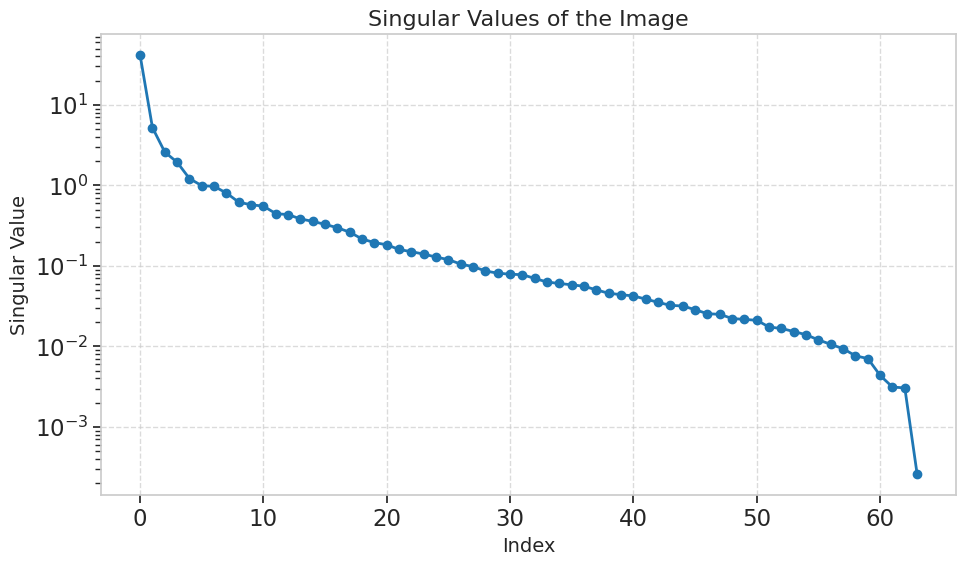

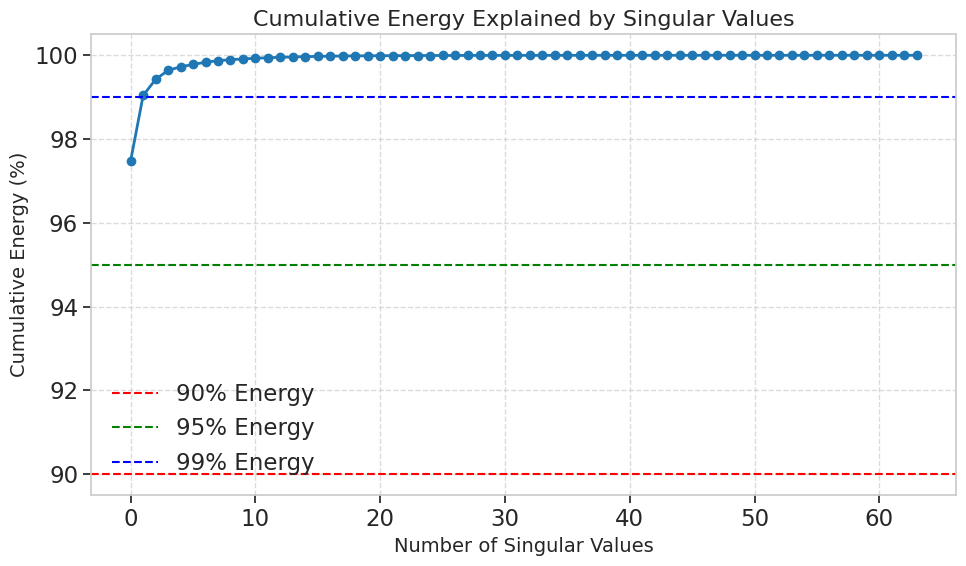

In [8]:
# Perform SVD on the image
U, S, V = torch.svd(face_image)

# Plot the singular values
plt.figure(figsize=(10, 6))
plt.plot(S.numpy(), 'o-', linewidth=2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Singular Values of the Image', fontsize=16)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Singular Value', fontsize=14)
plt.yscale('log')  # Use log scale to better see the distribution
plt.tight_layout()
plt.show()

# Plot the cumulative energy
cumulative_energy = torch.cumsum(S**2, dim=0) / torch.sum(S**2)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_energy.numpy() * 100, 'o-', linewidth=2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Cumulative Energy Explained by Singular Values', fontsize=16)
plt.xlabel('Number of Singular Values', fontsize=14)
plt.ylabel('Cumulative Energy (%)', fontsize=14)
plt.axhline(y=90, color='r', linestyle='--', label='90% Energy')
plt.axhline(y=95, color='g', linestyle='--', label='95% Energy')
plt.axhline(y=99, color='b', linestyle='--', label='99% Energy')
plt.legend()
plt.tight_layout()
plt.show()


## 3. Vibration Analysis

In mechanical engineering and structural analysis, eigenvalues and eigenvectors are used to find the natural frequencies and mode shapes of vibrating systems. Let's model a simple mass-spring system and analyze its vibration characteristics.

### Mass-Spring System

We'll model a linear system of masses connected by springs. The system's equation of motion can be written as:

$$M\ddot{x} + Kx = 0$$

where:
- $M$ is the mass matrix
- $K$ is the stiffness matrix
- $x$ is the displacement vector

The natural frequencies and mode shapes are found by solving the generalized eigenvalue problem:

$$Kv = \lambda Mv$$

Let's implement this for a simple system:


In [9]:
def analyze_mass_spring_system(masses, k_values):
    """
    Analyze a mass-spring system to find natural frequencies and mode shapes.
    
    Args:
        masses (list): Mass values
        k_values (list): Spring stiffness values
        
    Returns:
        tuple: (natural_frequencies, mode_shapes)
    """
    n = len(masses)
    
    # Construct mass matrix (diagonal)
    M = torch.diag(torch.tensor(masses, dtype=torch.float32))
    
    # Construct stiffness matrix
    K = torch.zeros((n, n), dtype=torch.float32)
    
    # For a chain of masses connected by springs:
    # Each mass is connected to its neighbors
    for i in range(n):
        if i > 0:  # Connection to left neighbor
            K[i, i] += k_values[i-1]
            K[i, i-1] = -k_values[i-1]
            K[i-1, i] = -k_values[i-1]
        if i < n-1:  # Connection to right neighbor
            K[i, i] += k_values[i]
    
    # Solve the generalized eigenvalue problem K*v = λ*M*v
    # This is equivalent to solving (M^-1 * K)*v = λ*v
    M_inv = torch.inverse(M)
    eigenvalues, eigenvectors = torch.linalg.eig(M_inv @ K)
    
    # Convert to real if eigenvalues are real
    eigenvalues_imag = eigenvalues.imag
    if torch.max(torch.abs(eigenvalues_imag)) < 1e-6:
        eigenvalues = eigenvalues.real
        eigenvectors = eigenvectors.real
    
    # Natural frequencies are sqrt(eigenvalues)
    # Note: eigenvalues could be complex in some cases
    natural_frequencies = torch.sqrt(eigenvalues)
    
    # Sort by increasing frequency
    idx = torch.argsort(natural_frequencies)
    natural_frequencies = natural_frequencies[idx]
    mode_shapes = eigenvectors[:, idx]
    
    return natural_frequencies, mode_shapes

# Define a simple system: 3 masses connected by springs
masses = [1.0, 2.0, 1.0]  # Three masses
k_values = [10.0, 20.0]   # Two springs connecting the masses

natural_frequencies, mode_shapes = analyze_mass_spring_system(masses, k_values)

print("Natural frequencies (rad/s):")
for i, freq in enumerate(natural_frequencies):
    print(f"Mode {i+1}: {freq.item():.4f}")

print("\nMode shapes (columns):")
print(mode_shapes)


Natural frequencies (rad/s):
Mode 1: 0.0010
Mode 2: 3.4917
Mode 3: 5.7278

Mode shapes (columns):
tensor([[-0.5774,  0.8564,  0.2301],
        [-0.5774, -0.1877, -0.5248],
        [-0.5774, -0.4809,  0.8195]])


### Visualizing Vibration Modes

Let's visualize the mode shapes and create animations of the different vibration modes:


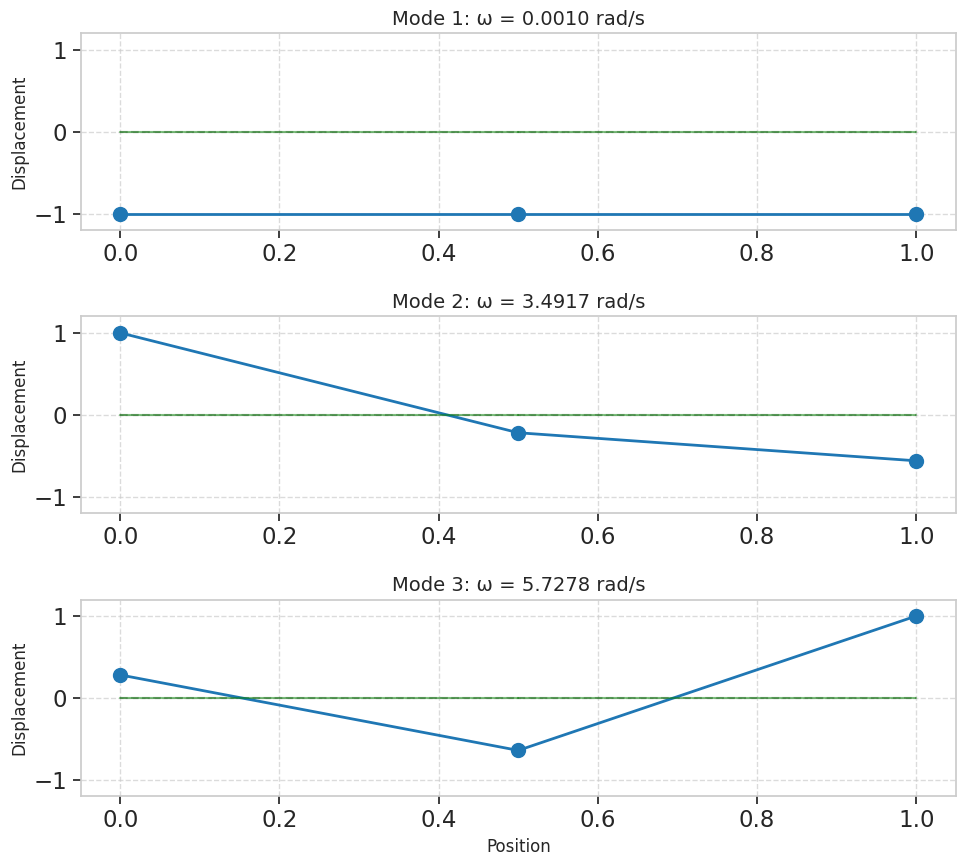

(<Figure size 1000x900 with 3 Axes>,
 array([<Axes: title={'center': 'Mode 1: ω = 0.0010 rad/s'}, ylabel='Displacement'>,
        <Axes: title={'center': 'Mode 2: ω = 3.4917 rad/s'}, ylabel='Displacement'>,
        <Axes: title={'center': 'Mode 3: ω = 5.7278 rad/s'}, xlabel='Position', ylabel='Displacement'>],
       dtype=object))

In [10]:
def visualize_vibration_modes(masses, k_values, mode_shapes, natural_frequencies):
    """Visualize the vibration mode shapes."""
    n_modes = len(natural_frequencies)
    n_masses = len(masses)
    
    # Position the masses equally spaced in equilibrium
    equilibrium_positions = np.linspace(0, 1, n_masses)
    
    # Create subplots for each mode
    fig, axes = plt.subplots(n_modes, 1, figsize=(10, 3*n_modes))
    if n_modes == 1:
        axes = [axes]
    
    # Plot each mode shape
    for i in range(n_modes):
        ax = axes[i]
        mode = mode_shapes[:, i].real
        
        # Normalize mode shape
        mode = mode / torch.max(torch.abs(mode))
        
        # Plot the masses in equilibrium position
        ax.plot(equilibrium_positions, np.zeros_like(equilibrium_positions), 'k--', alpha=0.3)
        
        # Plot the mode shape
        ax.plot(equilibrium_positions, mode, 'o-', linewidth=2, markersize=10)
        
        # Plot springs
        for j in range(n_masses-1):
            spring_x = np.linspace(equilibrium_positions[j], equilibrium_positions[j+1], 20)
            spring_y = np.zeros_like(spring_x)
            ax.plot(spring_x, spring_y, 'g-', alpha=0.5)
        
        # Add labels
        ax.set_title(f'Mode {i+1}: ω = {natural_frequencies[i].item():.4f} rad/s', fontsize=14)
        ax.set_ylabel('Displacement', fontsize=12)
        ax.set_ylim([-1.2, 1.2])
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Only add x-label to bottom plot
        if i == n_modes - 1:
            ax.set_xlabel('Position', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    return fig, axes

# Visualize the vibration modes
visualize_vibration_modes(masses, k_values, mode_shapes, natural_frequencies)


## 4. Markov Processes

In Markov processes, the steady-state distribution is an eigenvector of the transition matrix corresponding to the eigenvalue 1. This has applications in various fields including:

- Page ranking algorithms (like Google's PageRank)
- Population dynamics
- Economic models
- Chemical reaction networks

Let's implement and analyze a simple Markov process:


In [11]:
def analyze_markov_process(transition_matrix, max_iterations=100, tol=1e-10):
    """
    Analyze a Markov process to find its steady-state distribution.
    
    Args:
        transition_matrix (torch.Tensor): Transition probability matrix
        max_iterations (int): Maximum number of power iterations
        tol (float): Convergence tolerance
        
    Returns:
        tuple: (steady_state, convergence)
    """
    n = transition_matrix.shape[0]
    
    # Check if the matrix is a valid transition matrix
    row_sums = torch.sum(transition_matrix, dim=1)
    is_valid = torch.allclose(row_sums, torch.ones_like(row_sums))
    if not is_valid:
        print("Warning: Input is not a valid transition matrix. Row sums should be 1.")
    
    # Initial distribution (uniform)
    v = torch.ones(n) / n
    
    # Store convergence history
    convergence = [v.clone()]
    
    # Power iteration to find steady state
    for i in range(max_iterations):
        # Apply transition matrix
        v_new = v @ transition_matrix
        
        # Check convergence
        if torch.norm(v_new - v) < tol:
            v = v_new
            break
            
        # Update for next iteration
        v = v_new
        convergence.append(v.clone())
    
    return v, convergence

# Example: Weather Markov chain (Sunny, Cloudy, Rainy)
weather_transition = torch.tensor([
    [0.7, 0.2, 0.1],  # Sunny -> [Sunny, Cloudy, Rainy]
    [0.3, 0.4, 0.3],  # Cloudy -> [Sunny, Cloudy, Rainy]
    [0.2, 0.3, 0.5]   # Rainy -> [Sunny, Cloudy, Rainy]
])

steady_state, convergence = analyze_markov_process(weather_transition)

print("Weather Markov Chain")
print("Transition matrix:")
print(weather_transition)
print("\nSteady-state distribution:")
print(f"Sunny: {steady_state[0].item():.4f}")
print(f"Cloudy: {steady_state[1].item():.4f}")
print(f"Rainy: {steady_state[2].item():.4f}")

# Verify that this is an eigenvector with eigenvalue 1
result = steady_state @ weather_transition
print("\nVerification:")
print(f"π·P = {result}")
print(f"π = {steady_state}")
print(f"Error: {torch.norm(result - steady_state).item():.10f}")


Weather Markov Chain
Transition matrix:
tensor([[0.7000, 0.2000, 0.1000],
        [0.3000, 0.4000, 0.3000],
        [0.2000, 0.3000, 0.5000]])

Steady-state distribution:
Sunny: 0.4565
Cloudy: 0.2826
Rainy: 0.2609

Verification:
π·P = tensor([0.4565, 0.2826, 0.2609])
π = tensor([0.4565, 0.2826, 0.2609])
Error: 0.0000000000


### Visualizing Convergence to Steady State

Let's visualize how the state probabilities evolve and converge to the steady-state distribution:


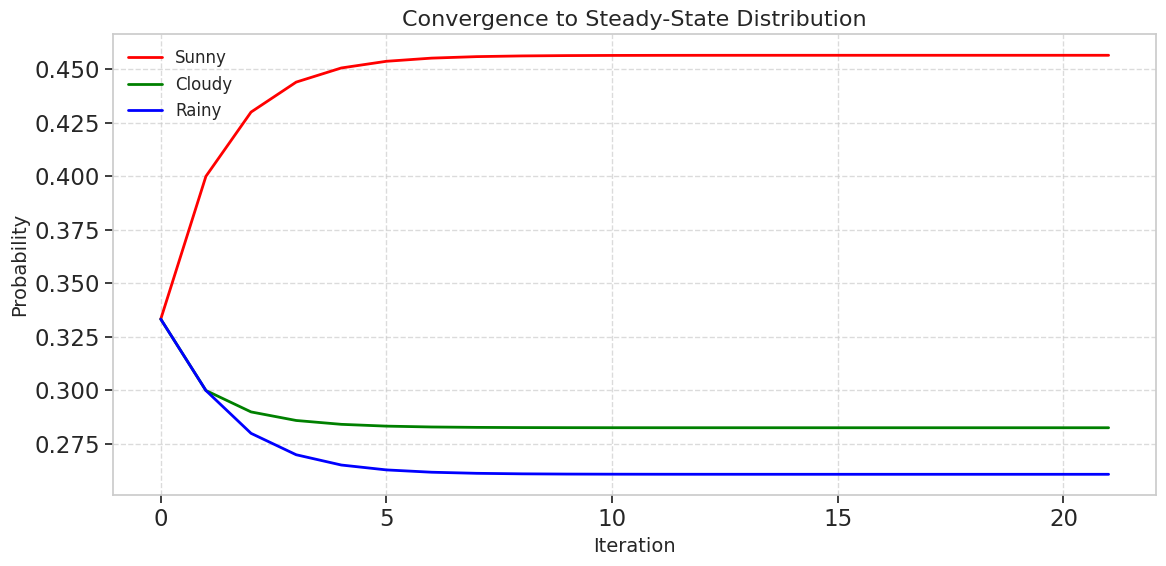

In [12]:
# Convert the convergence history to a numpy array for plotting
convergence_np = torch.stack(convergence).numpy()

plt.figure(figsize=(12, 6))
plt.plot(convergence_np[:, 0], 'r-', linewidth=2, label='Sunny')
plt.plot(convergence_np[:, 1], 'g-', linewidth=2, label='Cloudy') 
plt.plot(convergence_np[:, 2], 'b-', linewidth=2, label='Rainy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Convergence to Steady-State Distribution', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


### PageRank-like Algorithm

Let's implement a simple PageRank-like algorithm using the power method to find the principal eigenvector of a web graph adjacency matrix:


In [13]:
def pagerank(adjacency_matrix, damping=0.85, max_iterations=100, tol=1e-10):
    """
    Implement a PageRank-like algorithm.
    
    Args:
        adjacency_matrix (torch.Tensor): Adjacency matrix where A[i,j]=1 if there's a link from j to i
        damping (float): Damping factor, typically around 0.85
        max_iterations (int): Maximum number of power iterations
        tol (float): Convergence tolerance
        
    Returns:
        tuple: (page_ranks, convergence)
    """
    n = adjacency_matrix.shape[0]
    
    # Normalize columns to create transition matrix
    column_sums = torch.sum(adjacency_matrix, dim=0)
    column_sums[column_sums == 0] = 1  # Avoid division by zero for dangling nodes
    transition = adjacency_matrix / column_sums
    
    # Initial rank (uniform)
    ranks = torch.ones(n) / n
    
    # Store convergence history
    convergence = [ranks.clone()]
    
    # Power iteration with damping
    for i in range(max_iterations):
        # Apply PageRank update rule
        new_ranks = (1 - damping) / n + damping * (ranks @ transition)
        
        # Normalize to sum to 1
        new_ranks = new_ranks / torch.sum(new_ranks)
        
        # Check convergence
        if torch.norm(new_ranks - ranks) < tol:
            ranks = new_ranks
            break
            
        # Update for next iteration
        ranks = new_ranks
        convergence.append(ranks.clone())
    
    return ranks, convergence

# Example: Small web graph (5 pages)
web_graph = torch.tensor([
    [0, 1, 0, 0, 1],  # Page 0 <- [Pages 0,1,2,3,4]
    [1, 0, 1, 0, 0],  # Page 1 <- [Pages 0,1,2,3,4]
    [1, 1, 0, 1, 0],  # Page 2 <- [Pages 0,1,2,3,4]
    [0, 0, 1, 0, 1],  # Page 3 <- [Pages 0,1,2,3,4]
    [0, 0, 1, 1, 0]   # Page 4 <- [Pages 0,1,2,3,4]
])

page_ranks, pr_convergence = pagerank(web_graph)

print("PageRank Results:")
for i, rank in enumerate(page_ranks):
    print(f"Page {i}: {rank.item():.4f}")

# Verify using eigenvalue decomposition
# PageRank vector is the dominant eigenvector of the Google matrix
column_sums = torch.sum(web_graph, dim=0)
column_sums[column_sums == 0] = 1
transition = web_graph / column_sums
damping = 0.85
n = web_graph.shape[0]
google_matrix = (1 - damping) / n * torch.ones((n, n)) + damping * transition

eigenvalues, eigenvectors = torch.linalg.eig(google_matrix.T)
eigenvalues_imag = eigenvalues.imag
if torch.max(torch.abs(eigenvalues_imag)) < 1e-6:
    eigenvalues = eigenvalues.real
    eigenvectors = eigenvectors.real

# Find eigenvector corresponding to largest eigenvalue (should be 1)
# Make sure eigenvalues are real before doing argmax
eigenvalues_abs = torch.abs(eigenvalues)
idx = torch.argmax(eigenvalues_abs)
principal_eigenvector = eigenvectors[:, idx]
principal_eigenvector = principal_eigenvector / torch.sum(principal_eigenvector)

print("\nEigendecomposition results:")
print(f"Dominant eigenvalue: {eigenvalues[idx].item():.6f}")
print("Dominant eigenvector (normalized):")
for i, val in enumerate(principal_eigenvector):
    print(f"Page {i}: {val.item():.4f}")


PageRank Results:
Page 0: 0.2000
Page 1: 0.2000
Page 2: 0.2000
Page 3: 0.2000
Page 4: 0.2000

Eigendecomposition results:
Dominant eigenvalue: 1.000000+0.000000j
Dominant eigenvector (normalized):
Page 0: 0.2000+0.0000j
Page 1: 0.2000+0.0000j
Page 2: 0.2000+0.0000j
Page 3: 0.2000+0.0000j
Page 4: 0.2000+0.0000j


### Visualizing the Web Graph and PageRank


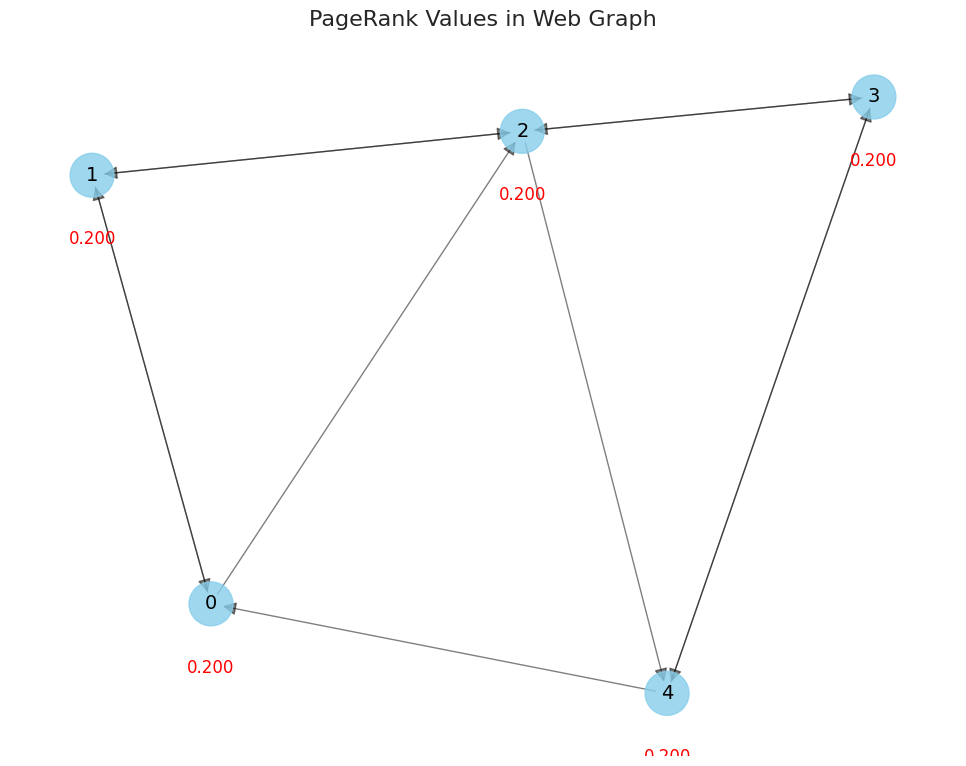

In [14]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges
n_pages = web_graph.shape[0]
for i in range(n_pages):
    G.add_node(i)

for i in range(n_pages):
    for j in range(n_pages):
        if web_graph[i, j] > 0:
            G.add_edge(j, i)  # Note: j->i because web_graph[i,j] means j links to i

# Set the layout
pos = nx.spring_layout(G, seed=42)

# Create the figure
plt.figure(figsize=(10, 8))

# Draw the graph
node_sizes = [5000 * rank.item() for rank in page_ranks]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', alpha=0.8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=14)

# Add ranks as labels
node_labels = {i: f"{page_ranks[i].item():.3f}" for i in range(n_pages)}
pos_labels = {k: (v[0], v[1] - 0.1) for k, v in pos.items()}
nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, 
                      font_color='red')

plt.title('PageRank Values in Web Graph', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()


## 5. Graph Analysis and Spectral Clustering

Eigenvalues and eigenvectors of the graph Laplacian matrix are used in spectral clustering, a powerful technique for community detection and graph partitioning.

Let's implement spectral clustering from scratch:


In [15]:
def spectral_clustering(adjacency_matrix, n_clusters=2):
    """
    Implement spectral clustering using the normalized graph Laplacian.
    
    Args:
        adjacency_matrix (torch.Tensor): Adjacency matrix of the graph
        n_clusters (int): Number of clusters to find
        
    Returns:
        tuple: (cluster_labels, eigenvectors, eigenvalues)
    """
    # Compute degree matrix
    degrees = torch.sum(adjacency_matrix, dim=1)
    D = torch.diag(degrees)
    
    # Compute the normalized Laplacian
    # L = I - D^(-1/2) A D^(-1/2)
    D_sqrt_inv = torch.diag(1.0 / torch.sqrt(degrees))
    L = torch.eye(adjacency_matrix.shape[0]) - D_sqrt_inv @ adjacency_matrix @ D_sqrt_inv
    
    # Compute eigenvalues and eigenvectors of the Laplacian
    eigenvalues, eigenvectors = torch.linalg.eigh(L)
    
    # Sort by eigenvalues (already sorted by eigh, but just to be explicit)
    idx = torch.argsort(eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Take the eigenvectors corresponding to the n_clusters smallest non-zero eigenvalues
    # Skip the first eigenvalue (which should be close to 0)
    cluster_eigenvectors = eigenvectors[:, 1:n_clusters+1]
    
    # Normalize rows to have unit length
    row_norms = torch.norm(cluster_eigenvectors, dim=1, keepdim=True)
    normalized_eigenvectors = cluster_eigenvectors / row_norms
    
    # Perform k-means clustering on the rows
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(normalized_eigenvectors.numpy())
    
    return cluster_labels, normalized_eigenvectors, eigenvalues


### Let's create a synthetic graph with two communities and apply spectral clustering:


In [16]:
def create_community_graph(n1=10, n2=10, p_within=0.7, p_between=0.1):
    """Create a synthetic graph with two communities."""
    n = n1 + n2
    adjacency = torch.zeros((n, n))
    
    # Within first community
    for i in range(n1):
        for j in range(i+1, n1):
            if torch.rand(1).item() < p_within:
                adjacency[i, j] = adjacency[j, i] = 1
    
    # Within second community
    for i in range(n1, n):
        for j in range(i+1, n):
            if torch.rand(1).item() < p_within:
                adjacency[i, j] = adjacency[j, i] = 1
    
    # Between communities
    for i in range(n1):
        for j in range(n1, n):
            if torch.rand(1).item() < p_between:
                adjacency[i, j] = adjacency[j, i] = 1
    
    # Ground truth communities
    ground_truth = torch.zeros(n, dtype=torch.long)
    ground_truth[n1:] = 1
    
    return adjacency, ground_truth

# Create a synthetic community graph
n1, n2 = 15, 15
adjacency, ground_truth = create_community_graph(n1, n2)

# Apply spectral clustering
cluster_labels, eigenvectors, eigenvalues = spectral_clustering(adjacency, n_clusters=2)

# Convert to tensors for consistency
cluster_labels = torch.tensor(cluster_labels, dtype=torch.long)

# Evaluate clustering accuracy
# Note: clusters might be flipped, so we check both ways
accuracy1 = torch.sum(cluster_labels == ground_truth).item() / len(ground_truth)
accuracy2 = torch.sum(cluster_labels == 1 - ground_truth).item() / len(ground_truth)
accuracy = max(accuracy1, accuracy2)

print(f"Spectral clustering accuracy: {accuracy:.2%}")


Spectral clustering accuracy: 100.00%


### Visualizing the Graph and Clustering Results


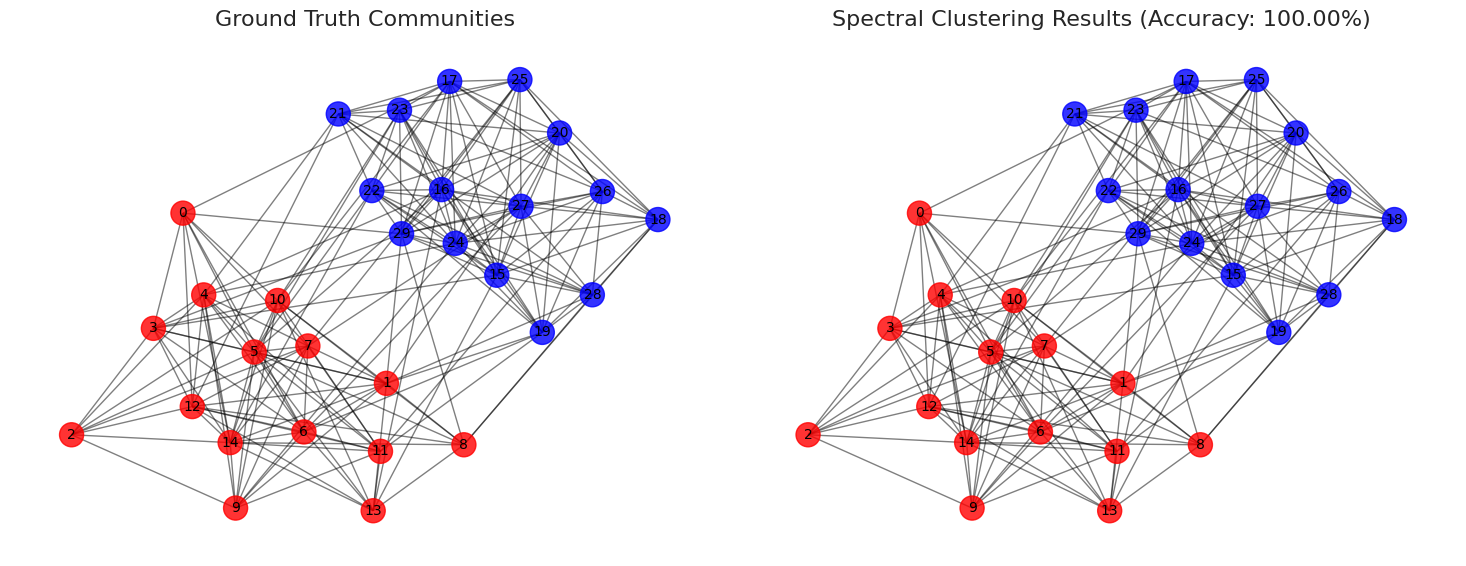

In [17]:
# Create a graph from the adjacency matrix
G_comm = nx.from_numpy_array(adjacency.numpy())

# Set the layout
pos_comm = nx.spring_layout(G_comm, seed=42)

# Plot the graph with clustering results
plt.figure(figsize=(15, 6))

# Original graph with ground truth
plt.subplot(121)
node_colors = ['red' if label == 0 else 'blue' for label in ground_truth]
nx.draw_networkx_nodes(G_comm, pos_comm, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G_comm, pos_comm, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G_comm, pos_comm, font_size=10)
plt.title('Ground Truth Communities', fontsize=16)
plt.axis('off')

# Graph with spectral clustering results
plt.subplot(122)
node_colors = ['red' if label == 0 else 'blue' for label in cluster_labels]
nx.draw_networkx_nodes(G_comm, pos_comm, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G_comm, pos_comm, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G_comm, pos_comm, font_size=10)
plt.title(f'Spectral Clustering Results (Accuracy: {accuracy:.2%})', fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()


### Visualizing the Spectral Embedding

The eigenvectors of the graph Laplacian provide a natural embedding of the graph in a low-dimensional space:


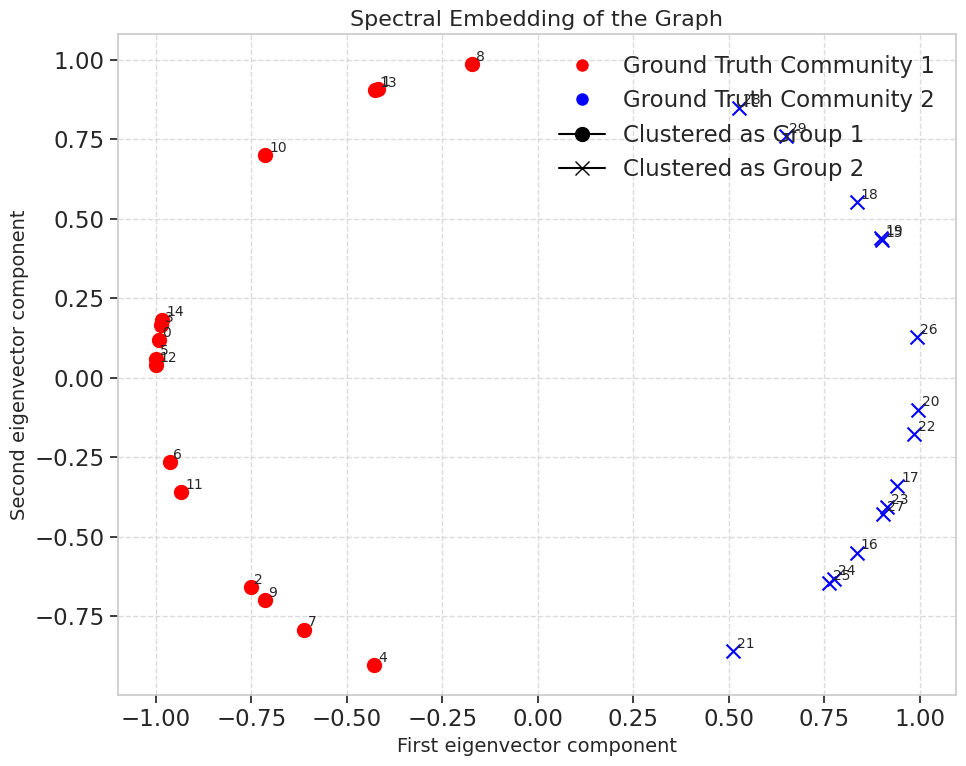

In [18]:
# Plot the 2D spectral embedding
plt.figure(figsize=(10, 8))
for i, label in enumerate(ground_truth):
    color = 'red' if label == 0 else 'blue'
    marker = 'o' if cluster_labels[i] == 0 else 'x'
    plt.scatter(eigenvectors[i, 0], eigenvectors[i, 1], color=color, marker=marker, s=100)
    plt.text(eigenvectors[i, 0]+0.01, eigenvectors[i, 1]+0.01, str(i), fontsize=10)

plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Spectral Embedding of the Graph', fontsize=16)
plt.xlabel('First eigenvector component', fontsize=14)
plt.ylabel('Second eigenvector component', fontsize=14)

# Add legend for colors (ground truth) and markers (clustering result)
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Ground Truth Community 1'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Ground Truth Community 2'),
    Line2D([0], [0], marker='o', color='k', markersize=10, label='Clustered as Group 1'),
    Line2D([0], [0], marker='x', color='k', markersize=10, label='Clustered as Group 2')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()


### Eigenvalues of the Graph Laplacian

The eigenvalues of the graph Laplacian provide insight into the structure of the graph. The number of connected components is equal to the multiplicity of the eigenvalue 0, and the magnitude of the second eigenvalue (the "spectral gap") relates to how well-connected the graph is.


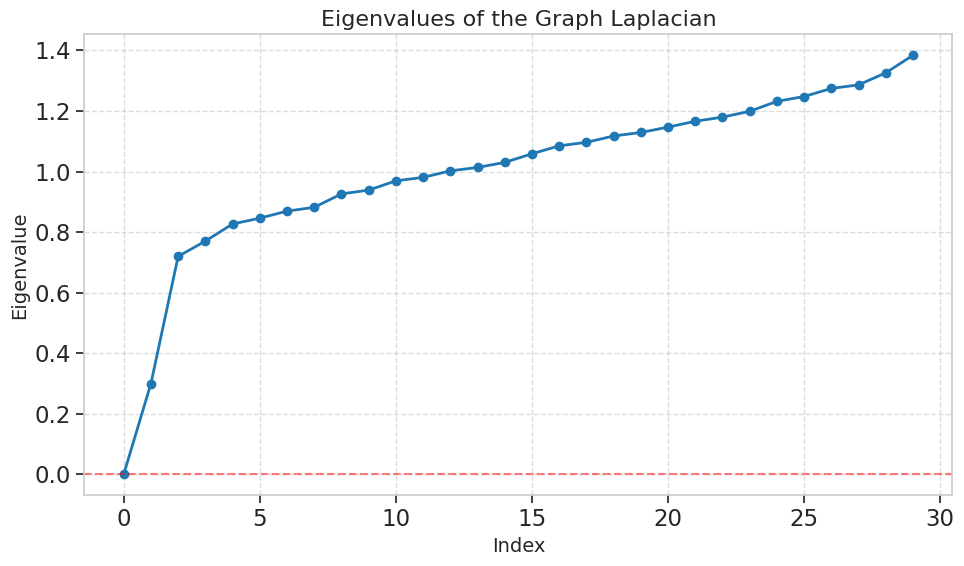

In [19]:
# Plot the eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(range(len(eigenvalues)), eigenvalues.numpy(), 'o-', linewidth=2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Eigenvalues of the Graph Laplacian', fontsize=16)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Eigenvalue', fontsize=14)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Conclusion

In this notebook, we've explored several practical applications of eigenvalues and eigenvectors:

1. **Principal Component Analysis (PCA)** for dimensionality reduction and data visualization
2. **Image Compression** using Singular Value Decomposition
3. **Vibration Analysis** to find natural frequencies and mode shapes in mechanical systems
4. **Markov Processes** to find steady-state distributions and implement PageRank-like algorithms
5. **Graph Analysis** using spectral clustering for community detection

These applications demonstrate how the eigenvalue decomposition provides powerful tools for analyzing and solving problems across many domains.

Key insights:

- Eigenvalues tell us about important scales or frequencies in our data or system
- Eigenvectors reveal important directions or modes that characterize the behavior
- Many applications can be formulated as finding the "most important" eigenvectors (corresponding to largest or smallest eigenvalues)
- Iterative methods like the power iteration allow us to find these important eigenvectors efficiently for large systems

By understanding eigenvalues and eigenvectors, we gain powerful tools for extracting meaning from complex data and systems.